# Local Multiple Trace Formulation for the Acoustic Scattering by composite objects

In this notebook, we consider the electromagnetic scattering from a composite object made up of 2 scatterers, namely a multitrace_sphere. We solve the problem using the (local) Multiple Trace Formulation. We use piecewise linear basis function and use squared operator preconditioning for GMRES.

We introduce the problem in a general setting.

Parameters: 

- $M$: Number of domains
- $k_0$: wavenumber for $\Omega_0$ (exterior domain)
- $\mu_0$: permeability for $\Omega_0$
- $n_i$: refractive index for $\Omega_i := \Omega_1 , ... \Omega_{M-1}$ (scatterers)

The skeleton is defined as:
$$\Sigma : = \bigcup_{i=0}^M \Gamma_i = \bigcup_{0 \leq i \leq j \leq M} \Gamma_{ij}
$$
and $\chi_{ij}:= 1_{\Gamma_{ij}}$ is the characteristic function for interface $\Gamma_{ij}$.


For $U_0:= U^s_0 + U_0^{inc}$ the (total) field in $\Omega_0$, we introduce $\mathbf{u}_0 := \mathbf{u}_0^{s} + \mathbf{u}_0^{inc}$ with

$$
 \quad
\mathbf{u}^s_0= \begin{bmatrix}
\gamma_{D} U_0^s \\[6pt]
\dfrac{1}{\mu_0} \gamma_{N} U_0^s
\end{bmatrix}, \quad \mathbf{u}^{inc}_0= \begin{bmatrix}
\gamma_{D} U_0^{inc} \\[6pt]
\dfrac{1}{\mu_0} \gamma_{N}U_0^{inc}
\end{bmatrix}.
$$

For $i = 0, \cdots, M$, the scaled Cauchy data read:
\begin{align}
\mathbf{u}_i = \begin{bmatrix}
\gamma_{D} U_i \\[6pt]
\dfrac{1}{\mu_i} \gamma_{N}U_i
\end{bmatrix}.
\end{align}

Furthermore, we define the scaled multitrace operators and transfert operators for $i,j = 0,\cdots , M$:
$$
\mathcal{A}_i = \begin{bmatrix}
-\mathcal{K}_i & \mu_i \mathcal{V}_i\\[6pt]
\frac{1}{\mu_i} \mathcal{W}_i & \mathcal{K}\prime_i 
\end{bmatrix},\quad \text{and} \quad% \mathcal{X}_{ij} = \begin{bmatrix}
%- \mathcal{I}_{ij} &0\\[6pt]
%0 & \mathcal{I}_{ij} \\
%\end{bmatrix},
$$

and set 
$$ \quad\mathbf{u} : =  \begin{bmatrix}\mathbf{u}_0 \\ \mathbf{u}_1\\ \vdots\\ \mathbf{u}_M\end{bmatrix},\quad \mathbf{u}^\text{inc} : =\begin{bmatrix}\mathbf{u}_0^{inc} \\ 0 \\ \vdots \\ 0\end{bmatrix}.$$

Finally, 
$$
\mathcal{A} := \text{diag}(\mathcal{A}_i),\quad \mathcal{X} := [\mathcal{X}_{ij}],
$$
with
$$
\mathcal{X}_{ij}= \chi_{ij}\mathcal{I}_{ij}.
$$
The local MTF boundary integral equation reads:
$$
(2 \mathcal{A} + \mathcal{X} ) \mathbf{u} = -2 \mathbf{u}^\text{inc}.
$$


We start with the usual imports and enable console logging. We use a precision of $10$ elements per wavelength. 

Throughout this script, we set $\mu_0=\mu_1=\mu_2=1$.

In [39]:
import bempp.api 
import numpy as np
from bempp.api.operators.boundary.sparse import identity
from bempp.api.assembly.blocked_operator import BlockedOperator, GeneralizedBlockedOperator

from bempp.api import ZeroBoundaryOperator
bempp.api.enable_console_logging()

#M = 2
M = 3
k0 = 1

mu0 = 1

refractivei = [1.5, 1.2]
mui = [1., 1.]

precision = 10

h = 2 * np.pi/(precision*k0)
print(h, ': h')
print(precision, ': precision')

0.6283185307179586 : h
10 : precision


We introduce the grid for the multitrace_cube. The grid is with Physical Surfaces from 1 to 11. 
- Scatterer $\Omega_1$ corresponds to Physical Surfaces [1,2,3,4,5,6]
- Scatterer $\Omega_2$ corresponds to Physical Surfaces [6,7,8,9,10,11]
- Exterior domain $\Omega_0$ corresponds to Physical Surfaces [1,2,3,4,5,7,8,9,10,11]

Moreover, interfaces $\Gamma_{ij}$ are with normal vectors pointing from $i$ to $j$, $i<j$, and Physical Surface [6] corresponds to $\Gamma_{12}$.
We aim at swapping normals appropriately for each domain, in order to work with domains with normal vectors pointing towards the exterior.

- Scatterer $\Omega_1$ is with normal vector pointing towards the exterior.
- Scatterer $\Omega_2$ is with normal vector pointing towards the interior for Physical Surface [6].
- Scatterer $\Omega_0$ is with normal vector pointing towards the interior.

Accordingly, we define segments and swapped_normals. 

In [40]:
grid = bempp.api.shapes.multitrace_sphere(h=h)
segments = [[10,20],[10,12],[12,20]]
swapped_normals = [[10,20],{},[12]]

#grid = bempp.api.shapes.sphere(h=h)
#segments = [[10],[10]]
#swapped_normals = [[10], {}]
interface = [12]

bempp:HOST:INFO: Created grid with id 2b4ba3db-1aec-40b2-9f1e-cbf34d0704f1. Elements: 144. Edges: 210. Vertices: 69


We define the input parameters and functions spaces for the operators. 

- d: domain spaces
- r: range spaces
- t: dual to range spaces
- A: Impedance matrix


In [41]:
k_list = [k0] 
mu_list = [mu0]
for index in range(M-1):
  k_list.append(refractivei[index] * k0)
  mu_list.append(mui[index])

    
dA = [bempp.api.function_space(grid, "P", 1, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]
rA = [bempp.api.function_space(grid, "P", 1, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]
tA = [bempp.api.function_space(grid, "P", 1, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]


We assembly the multitrace operators for each subdomain, and the MTF operator.


In [42]:
multitrace_ops = []
# > Assemble all diagonal operators
for index in range(M):
  k = k_list[index]
  mu = mu_list[index]

  V = bempp.api.operators.boundary.helmholtz.single_layer(dA[index], rA[index], tA[index], k, assembler='dense')
  K = bempp.api.operators.boundary.helmholtz.double_layer(dA[index], rA[index], tA[index], k, assembler='dense')
  Kp = bempp.api.operators.boundary.helmholtz.adjoint_double_layer(dA[index], rA[index], tA[index], k, assembler='dense')
  W = bempp.api.operators.boundary.helmholtz.hypersingular(dA[index], rA[index], tA[index], k, assembler='dense')  

  #multitrace_ops.append(bempp.api.GeneralizedBlockedOperator([[mfie, mu/k * efie],[- k/mu * efie, mfie]]))
  multitrace_ops.append(bempp.api.GeneralizedBlockedOperator([[-K, V],[W, Kp]]))

# Define the final operator

block_system = [M * [None] for _ in range(M)]
A = [M * [None] for _ in range(M)]
X = [M * [None] for _ in range(M)]

for i in range(M):
  for j in range(M):
    opZ = BlockedOperator(2, 2)
    zero = ZeroBoundaryOperator(dA[j], rA[i], tA[i])
    opZ[0, 0] = zero
    opZ[1, 1] = zero
    
    if i == j:
      block_system[i][j] = 2 * multitrace_ops[i]
      A[i][j] = 2 * multitrace_ops[i]
      X[i][j] = opZ
    else:
      A[i][j] = opZ  
      all = segments[i] + segments[j]
      non_disjoint = np.unique(all).shape[0] != len(all)
      
      if non_disjoint:
        ident = identity(dA[j], rA[i], tA[i])
        op = BlockedOperator(2, 2)
        #op[0, 0] = -ident
        op[0, 0] = -ident
        op[1, 1] = ident
        op.weak_form()
        #op[1, 1] = ident
        block_system[i][j] = op
        X[i][j] = op

      else:
        
        block_system[i][j] = op

        

block_system = GeneralizedBlockedOperator(block_system)
A = GeneralizedBlockedOperator(A)
X = GeneralizedBlockedOperator(X)


We assembly of the right-hand side.

In [43]:

@bempp.api.complex_callable
def dirichlet_fun(x, n, domain_index, result):
    result[0] = np.exp(1j * k0 * x[0])
    
@bempp.api.complex_callable
def neumann_fun(x, n, domain_index, result):
    result[0] = 1j * k0 * n[0] * np.exp(1j * k0 * x[0])


rhs = [-2 * bempp.api.GridFunction(rA[0], dual_space = tA[0], fun=dirichlet_fun),
       -2 * bempp.api.GridFunction(rA[0], dual_space = tA[0], fun=neumann_fun)]
for i in range(1, M):
    zero_func = [bempp.api.GridFunction.from_zeros(dA[i]),bempp.api.GridFunction.from_zeros(dA[i])]
    rhs = rhs + zero_func



We solve the linear system in weak form, with a direct solver, and verify that the trace jumps across $\Gamma_{12}$ are small.

In [44]:

print('weak_form')
block_system_wf = block_system.weak_form()
print('matrix')
Am = bempp.api.as_matrix(block_system_wf)
print('direct solver')
b = bempp.api.assembly.blocked_operator.projections_from_grid_functions_list(rhs, block_system.dual_to_range_spaces)
x = np.linalg.solve(Am, b)
sol = bempp.api.assembly.blocked_operator.grid_function_list_from_coefficients(x.ravel(), block_system.domain_spaces)




B = bempp.api.as_matrix((A * (A + X)).strong_form())
print('b2')
B2 = bempp.api.as_matrix((block_system * block_system).strong_form())
print('res')
###################
# Results

interface_space = bempp.api.function_space(grid, "P", 1, segments=[12], include_boundary_dofs = True)

#map_dom0_to_interface = identity(sol[0].space, interface_space, interface_space)
#map_dom1_to_interface = identity(sol[2].space, interface_space, interface_space)

#triple
map_dom0_to_interface = identity(sol[2].space, interface_space, interface_space)
map_dom1_to_interface = identity(sol[4].space, interface_space, interface_space)

#trace0i = map_dom0_to_interface @ sol[0]
#trace1i = map_dom1_to_interface @ sol[2]

trace0i = map_dom0_to_interface @ sol[2]
trace1i = map_dom1_to_interface @ sol[4]

#normal_trace0i = map_dom0_to_interface @ sol[1]
#normal_trace1i = map_dom1_to_interface @ sol[3]

normal_trace0i = map_dom0_to_interface @ sol[3]
normal_trace1i = map_dom1_to_interface @ sol[5]

dirichlet_jump = (trace0i - trace1i).l2_norm() / (trace0i.l2_norm())
neumann_jump = (normal_trace0i + normal_trace1i).l2_norm() / (normal_trace0i.l2_norm())

print(dirichlet_jump,': L^2 relative error for tangential traces')
print(neumann_jump,': L^2 relative error for magnetic traces')



weak_form


/Users/paul/opt/miniconda3/envs/exabem/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


matrix
direct solver
b2
res
0.030606797492397236 : L^2 relative error for tangential traces
0.25089739987661136 : L^2 relative error for magnetic traces


In [45]:
# STF

gmres= bempp.api.linalg.gmres(block_system * block_system, block_system * rhs, use_strong_form=True, return_residuals=True, return_iteration_count = True, maxiter = 100)


#gmres= bempp.api.linalg.gmres(A * block_system, block_system * rhs, use_strong_form=True, return_residuals=True, return_iteration_count = True, maxiter = 100)

bempp:HOST:INFO: Starting GMRES iteration
bempp:HOST:INFO: GMRES Iteration 1 with residual 0.6404929868381062
bempp:HOST:INFO: GMRES Iteration 2 with residual 0.3607827870681978
bempp:HOST:INFO: GMRES Iteration 3 with residual 0.2105662165035313
bempp:HOST:INFO: GMRES Iteration 4 with residual 0.05051089883319188
bempp:HOST:INFO: GMRES Iteration 5 with residual 0.01731835001705707
bempp:HOST:INFO: GMRES Iteration 6 with residual 0.007548690818444219
bempp:HOST:INFO: GMRES Iteration 7 with residual 0.0021737970408486507
bempp:HOST:INFO: GMRES Iteration 8 with residual 0.0008438273218286861
bempp:HOST:INFO: GMRES Iteration 9 with residual 0.00021407193612830205
bempp:HOST:INFO: GMRES Iteration 10 with residual 5.597588168989859e-05
bempp:HOST:INFO: GMRES Iteration 11 with residual 1.9805770146375476e-05
bempp:HOST:INFO: GMRES Iteration 12 with residual 4.6700682711820335e-06
bempp:HOST:INFO: GMRES finished in 12 iterations and took 5.11E-01 sec.


# Eigenvalues analysis and preconditioning


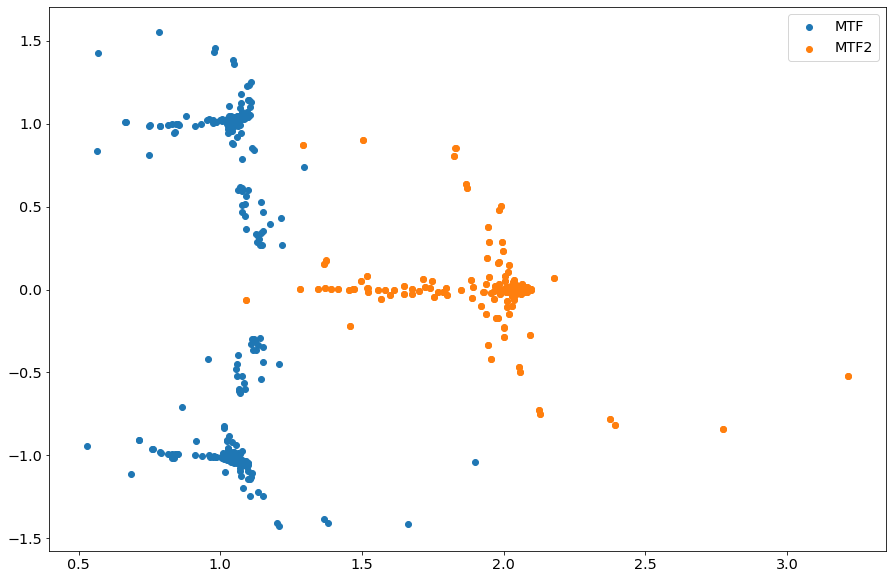

In [46]:
import numpy as np
eig2 = np.linalg.eigvals(B2)
eig = np.linalg.eigvals(B)
from matplotlib import pyplot as plt

plt.scatter(eig.real, eig.imag, label = 'MTF')
plt.scatter(eig2.real, eig2.imag, label = 'MTF2')
plt.legend()

In [47]:
print(trace0i.coefficients[:10])
print(trace1i.coefficients[:10])
print(normal_trace0i.coefficients[:10])
print(normal_trace1i.coefficients[:10])

[1.19142024+0.23159015j 1.19802744+0.22060711j 1.19143665+0.22461052j
 1.19925768+0.22414555j 1.19903854+0.21996305j 1.18434014+0.23064421j
 1.18519996+0.22587307j 1.18368416+0.23061859j 1.19544461+0.22260679j
 1.20261269+0.21663243j]
[1.16689863+0.29568294j 1.16334127+0.28942256j 1.15790501+0.28606218j
 1.16657382+0.28818743j 1.16137872+0.28765117j 1.16279356+0.29953017j
 1.15599183+0.28414031j 1.15660698+0.28148209j 1.16188386+0.29307991j
 1.15827691+0.27509109j]
[-0.33236509+0.39491911j -0.32340346+0.34966014j -0.29207187+0.52428193j
 -0.33224196+0.50049717j -0.31207113+0.45534991j -0.37831281+0.1535249j
 -0.37602622+0.25794616j -0.32119923+0.42700201j -0.36388448+0.25651423j
 -0.2262773 +0.78039554j]
[-0.04589972-0.69976272j -0.21982894-0.48645441j -0.20499444-0.56097056j
 -0.10767122-0.65118086j -0.25063849-0.45290499j -0.07531569-0.70802135j
 -0.25257299-0.48245556j -0.15419483-0.57121448j -0.14133722-0.59312203j
 -0.24528039-0.40956429j]


We compute the Far-Field pattern:
    

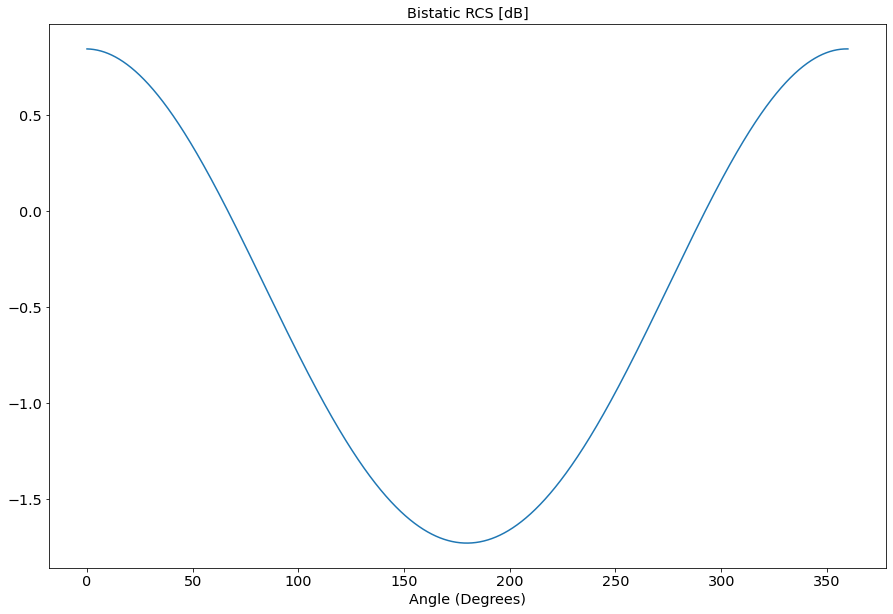

In [48]:
number_of_angles = 3601
angles = np.pi * np.linspace(0, 2, number_of_angles)
unit_points = np.array([np.cos(angles), np.sin(angles), np.zeros(number_of_angles)])


single_far = bempp.api.operators.far_field.helmholtz.single_layer(sol[1].space, unit_points, k0)
double_far = bempp.api.operators.far_field.helmholtz.double_layer(sol[0].space, unit_points, k0)    

far_field = - single_far * sol[1] + double_far * sol[0]


from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure()
plt.rcParams['figure.figsize'] = (15, 10) # Increase the figure size in the notebook
params = {'legend.fontsize': 'x-large', 'axes.labelsize': 'x-large', 'axes.titlesize': 'x-large',
         'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'}
plt.rcParams.update(params)

bistatic_rcs= 10 * np.log10(4 * np.pi * np.sum(np.abs(far_field)**2, axis=0))
plt.plot(angles * 180 / np.pi, bistatic_rcs)

plt.title("Bistatic RCS [dB]")
_ = plt.xlabel('Angle (Degrees)')